## Imports

In [1]:
## Link: https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
import os
import re
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import scipy.signal as scisig
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib as mpl
import heartpy as hp
import biosppy
import neurokit2 as nk
from heartpy.datautils import *
from heartpy.peakdetection import *
mpl.rcParams['agg.path.chunksize'] = 10000
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
import csv 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

# Feature Extraction

Features coded:

ECG: mean, std, min, max, bpm, ibi, sdnn, sdsd, rmssd, pnn20, pnn50, 


PPG/BVP: mean, std, min, max, peak_freq

TEMP:mean, std, min, max, drange, slope

RESP: mean, std, min, max, rate; Inh: mean, std; Exh: mean, std, I/E


EDA: mean, std, min, max, slipe, drange; SCR: mean, std, min, max; SCL: mean, std, min, max

ACC x,y,z; chest, wrist:  mean, std, min, max, abs_integral, peak_freq
Acc net: mean, std, min, max, abs_integral, peak_freq


Features not coded yet:


To replicate this study with similar modalities to RADWear, I will drop the following signals: EDA_c, EMG, TEMP_C

## Parameters

In [2]:
# E4 (wrist) Sampling Frequencies
fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700, 'ECG': 700, 
           'chest': 700}
# Window size
WINDOW_IN_SECONDS = 60
stride = 0.25

# Labels
label_dict = {'baseline': 1, 'stress': 2, 'amusement': 0}
# Int to label mappings
int_to_label = {1: 'baseline', 2: 'stress', 0: 'amusement'}
# Feature names
feat_names = None
# Where to save the data
savePath = 'data/WESAD'
# Where to get the data
subject_feature_path = '/subject_feats'

if not os.path.exists(savePath):
    os.makedirs(savePath)
if not os.path.exists(savePath + subject_feature_path):
    os.makedirs(savePath + subject_feature_path)

In [3]:
# Data import
os.listdir(savePath)
df = pd.read_csv(savePath +'/oct5_feats4.csv', index_col=0)
pd.set_option('display.max_columns', None) 


We want to drop columns in df that are not in RADWear to match modalities. 

In [4]:
# drop _c columns
columns_list = df.columns.tolist()
drop_list = []
#df.drop(columns=['Resp_C'])
for column in columns_list:
    if 'EMG' in column or 'EDA_C' in column or 'Temp_C' in column or 'TEMP_C' in column or 'SCR_C' in column or 'SCL_C' in column:
        drop_list.append(column)

reduced_df = df.drop(columns=drop_list)
df = reduced_df

## Generate correlation between features and labels

In [ ]:
df = pd.read_csv(savePath +'/oct5_feats4.csv', index_col=0)


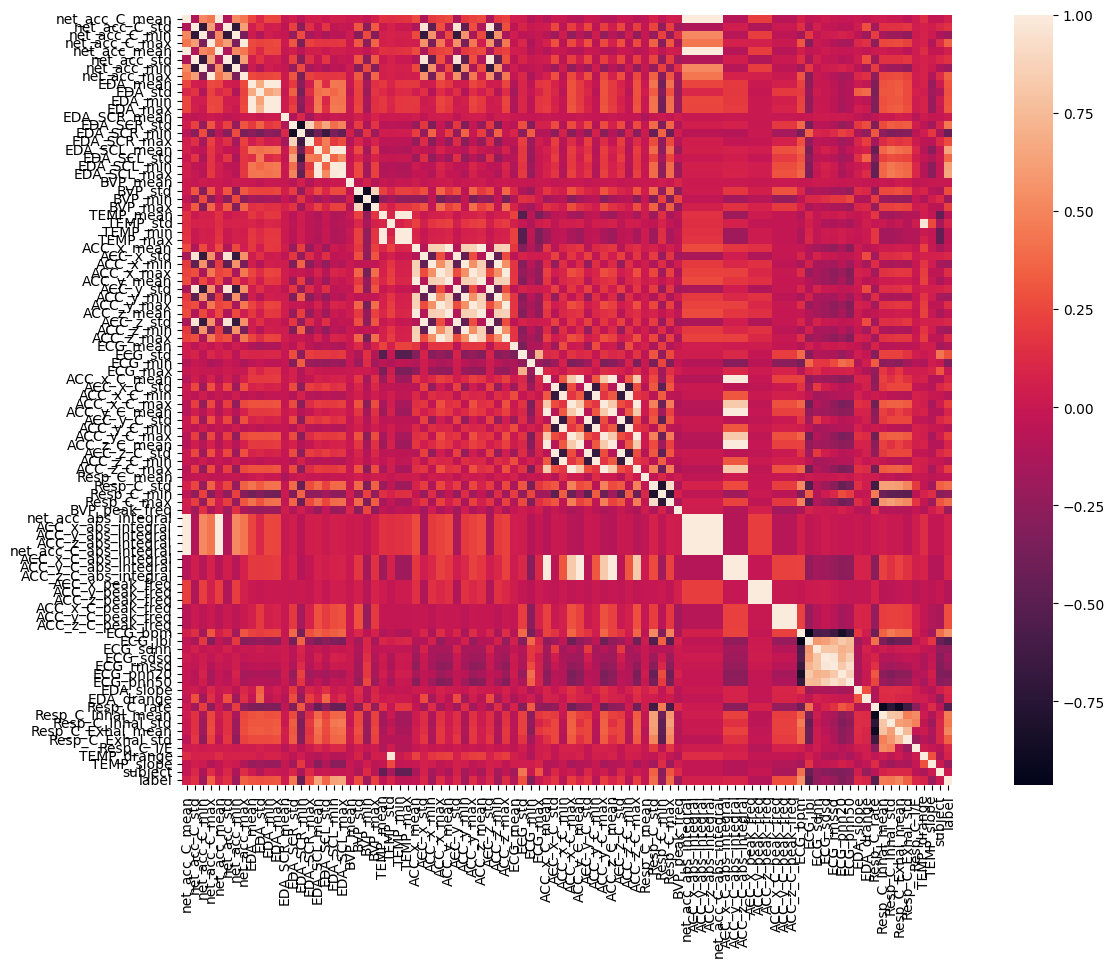

In [5]:
vals = abs(df.corr()['label']).sort_values(ascending=False)
if False:
    for i in range(len(vals)):
        print(vals.index[i], vals[i])

corr = df.corr()
plot_corr = True
if plot_corr:
    plt.figure(figsize=(16,10))
    sns.heatmap(corr,xticklabels=True, yticklabels=True,square=True)

In [6]:
# df = df.loc[:, df.columns != 'Resp_C_rate'] #I don't know why this is here. 

features = df.loc[:, df.columns != 'label'].columns
print_feats_list = False
if print_feats_list:
    for ft_idx in range(len(features)):
        print(features[ft_idx], ft_idx)

## split data into train and test set

In [7]:

X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

# Modeling

## Cross Validation

### K-Fold Cross Validation

### Leave-One-Out Cross Validation

# Models 

The models will be included in this study are: 

DT, RF, AB, LDA and kNN. 

Completed: LDA, RF, SVM, 

Incomplete: AB, DT, kNN  

## Linear Discriminant Analysis

In [8]:
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  
lda_baseline_acc = accuracy_score(y_test, y_pred)

[[11  8  1]
 [ 2 65  1]
 [ 0  0 28]]
Accuracy: 0.896551724137931


### Feature Importance (Top 20)

## Random Forest Classifier

In [9]:
classifier = RandomForestClassifier(max_depth=4, random_state=0)
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

In [10]:
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  
rf_baseline_acc = accuracy_score(y_test, y_pred)

[[ 9 10  1]
 [ 0 68  0]
 [ 1  0 27]]
Accuracy: 0.896551724137931


### Feature Importance (Top 20)

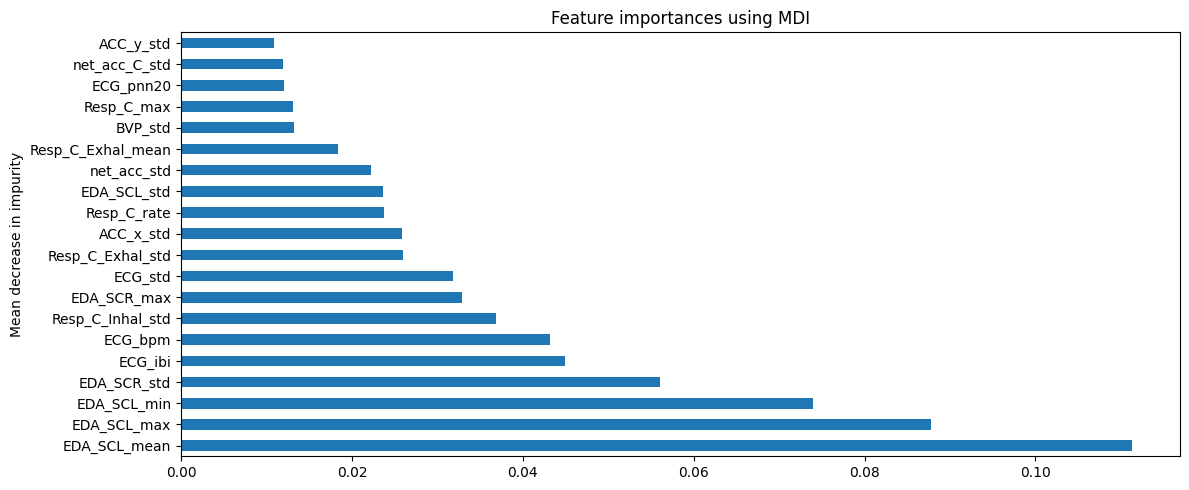

In [11]:
importances = classifier.feature_importances_
forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Support Vector Machine

### Linear SVM

In [12]:
# Create a SVC classifier using a linear kernel
clf = SVC(kernel='linear', C=1, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_out = clf.predict(X_test)
lm_svc=(classification_report(y_test, y_out, digits=4))
print(lm_svc)
svm_baseline_acc = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.7619    0.8000    0.7805        20
           1     0.9394    0.9118    0.9254        68
           2     0.9655    1.0000    0.9825        28

    accuracy                         0.9138       116
   macro avg     0.8889    0.9039    0.8961       116
weighted avg     0.9151    0.9138    0.9142       116



### Feature Importance (Top 20)

<Axes: >

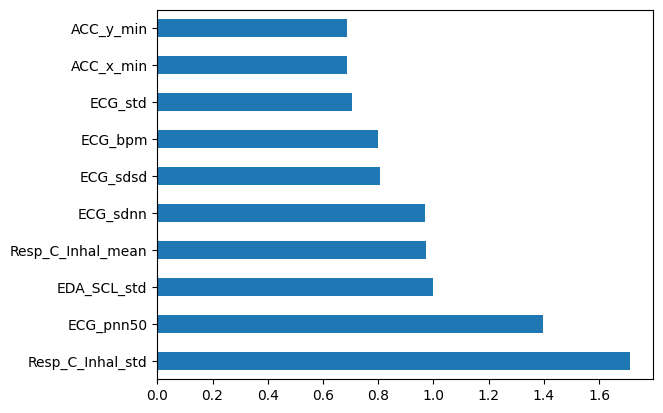

In [13]:
pd.Series(abs(clf.coef_[0]), index=features).nlargest(10).plot(kind='barh')

### Linear SVM (lambda 2)

In [14]:
# Create a SVC classifier using a linear kernel
clf = SVC(kernel='linear', C=0.9, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_out = clf.predict(X_test)
lm_svc=(classification_report(y_test, y_out, digits=4))
print(lm_svc)
svm_baseline_acc = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.7895    0.7500    0.7692        20
           1     0.9265    0.9265    0.9265        68
           2     0.9655    1.0000    0.9825        28

    accuracy                         0.9138       116
   macro avg     0.8938    0.8922    0.8927       116
weighted avg     0.9123    0.9138    0.9129       116



### Feature Importance (Top 20)

<Axes: >

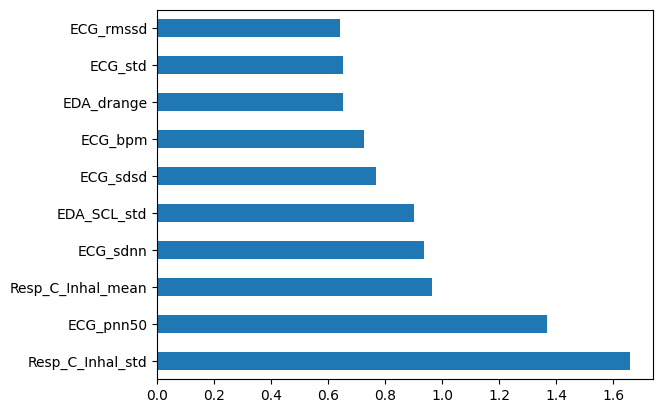

In [15]:
pd.Series(abs(clf.coef_[0]), index=features).nlargest(10).plot(kind='barh')

## Adaboost 

In [16]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ab_baseline_acc = accuracy_score(y_test, y_pred)
ab_baseline_acc = clf.score(X_test, y_test)
print('adaboost baseline accuracy: ' + str(ab_baseline_acc))

adaboost baseline accuracy: 0.7413793103448276


### Feature Importance (Top 20)

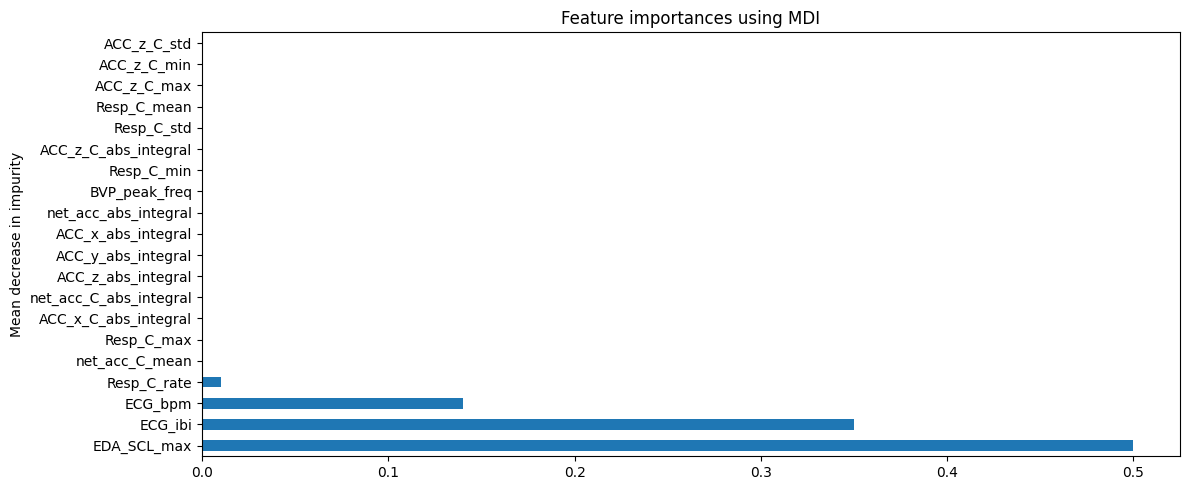

In [17]:
ab_imp = clf.feature_importances_
ab_imp = pd.Series(ab_imp, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
ab_imp[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Decision Tree 

In [18]:

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
dt_baseline_acc = accuracy_score(y_test, y_pred)
print('decision tree baseline accuracy: ' + str(dt_baseline_acc))

decision tree baseline accuracy: 0.853448275862069


### Feature Importance (Top 20)

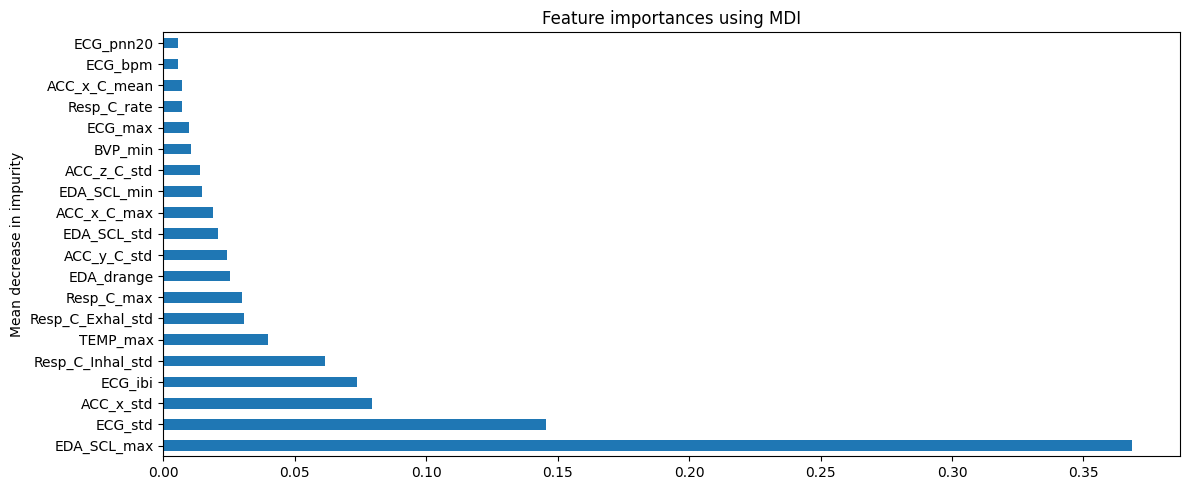

In [19]:
dt_importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
dt_importances[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## k-Nearest Neighbors 

In [20]:

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier() #(n_neighbors=3)


#y_pred = knn.predict(X_test)
#knn_baseline_acc = accuracy_score(y_test, y_pred)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
knn_baseline_acc = nca_pipe.score(X_test, y_test)
print('knn baseline accuracy: ' + str(knn_baseline_acc))

knn baseline accuracy: 0.9568965517241379


### Feature Importance (Top 20)

Feature importance cannot be discovered for the kNN model. 

# Adding Noise

## Signal to Noise Ratio

For a non-constant signal $S$ and noise $N$, the signal to noise ratio is defined as the following:
$$ SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]} $$

The expected value $\mathbb{E}[X]$ of any continuous random variable $X$ is $\int_{-\infty}^{\infty} x p(x) dx $, where $p(x)$ is its associated probability density function.

For homoskedastic noise, we can use closed form expressions to compute $E[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$.

- For uniformly distributed noise $N$ ~ $u(\alpha, \beta)$, by the same logic as above $\mathbb{E}[N^2] = \left(\frac{\alpha - \beta}{2}\right)^2$.

- For frequency-domain noise $N$ of the form $A\sin(2\pi x \frac{1}{f}) + y, \mathbb{E}[N^2] \approx y^2 + \frac{A^2}{2}$. Note the $\approx$ since we cannot guarantee that the signal will end precisely on the end of the sin wave.

For heteroskedastic noise, because there is no closed form expression, we simply take `N.mean()` where $N$ is our noise

In [21]:
def signal_to_noise_ratio(signal, noise_type, noise_dist, noise=None, sigma=None, alpha=None, beta=None, 
                          vertical_shift=None, amplitude=None):
    """
    Function: Computes the signal to noise ratio for a given signal and its corresponding noise.
    
    :param:
        signal (array or ndarray): The signal we are evaluating
        noise_type (string): 'Heteroskedastic' or 'Homoskedastic'
        noise_dist (string): 'Uniform', 'Gaussian', or 'Frequency' for now
        noise (array or ndarray): Only passed in if we have heteroskedastic noise
        sigma (float): Sigma parameter of the gaussian
        alpha (float): Alpha parameter of the uniform
        beta (float): Beta parameter of the uniform
        vertical_shift (float): Vertical shift parameter of the frequency
        amplitude (float): Amplitude parameter of the frequency
        
    :return
        signal_to_noise_ratio (float): Signal to noise ratio... E[S^2]/E[N^2]
    """
    
    # Calculate E[S^2]
    e_s2 = (signal**2).mean()
    e_n2 = None
    
    if noise_type == 'Homoskedastic':
        # Calculate E[N^2] for the pertinent case
        if noise_dist == 'Uniform':
            e_n2 = (0.5*(alpha - beta))**2
        elif noise_dist == 'Gaussian':
            e_n2 = sigma**2
        elif noise_dist == 'Frequency':
            e_n2 = vertical_shift**2 + (amplitude**2)/2
    elif noise_type == 'Heteroskedastic':
        e_n2 = (noise**2).mean()
    
    # Return the signal to noise ratio
    return e_s2/e_n2

## Denoising Using Principal Component Analysis

Let $X$ represent our set of physiological signals and $\textbf{x}_i$ denote the *i*-th column of $X$. In our case, $\textbf{x}_i$ is one of the ECG, BVP, EDA, ACC, etc. The post-noise signal we observe $\textbf{x}_i = \widetilde{\textbf{x}}_i + \xi_i$ is composed of the original raw signal and Gaussian distributed noise with $\mathbb{E}[\xi] = 0$ and $V[\xi] = E[N^2] = \sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$. Literature has indicated that a principal component analysis of $\textbf{x}_i$ can produce an estimate of $\widetilde{\textbf{x}}_i$ that is closer than the noisy measurements are (citation needed).

## Calculate Distribution Parameters from SNR

Given a signal $S$, we can specify a signal to noise ratio $SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]}$ and use this to calculate $\mathbb{E}[N^2]$ because $SNR$ and $\mathbb{E}[S^2]$ are known. So $\mathbb{E}[N^2] = \frac{\mathbb{E}[S^2]}{SNR}$.

Then, for any homoskedastic noise following a well-defined probability density function (PDF), we can solve for the parameters of the PDF using the known value $\mathbb{E}[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$. Thus, $\sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$.

In [22]:
def calculate_param(signal, noise_type, signal_to_noise_ratio):
    """
    Function: Calculates the parameters of a continuous probability density function given
    our desired signal to noise ratio and signal.
    
    :param:
        signal (array or ndarray): Our signal
        noise_type (string): Probability distribution of our noise (i.e., Gaussian)
        signal_to_noise_ratio (float): Desired signal to noise ratio
    
    :return
    (for now, just)
        sigma (float): sigma of the gaussian
    """
    
    return (signal**2).mean()/signal_to_noise_ratio

## Gaussian Noise

The Gaussian probability density function is of the following form:
\begin{equation}
f(x) = \frac{1}{\sigma \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right)
\end{equation}

### Estimating $\mu$ and $\sigma$ of the Gaussian

#### Greatest $n$-Differential with Homoskedasticity Approach

For a signal $S$, the greatest $n$-differential with homoskedasticity approach constructs a Gaussian distribution such that $\mu$ = 0 and $\sigma = \alpha \cdot max(|S_i - S_{i+n}|)$, where $max(|S_i - S_{i+n}|)$ denotes the maximum absolute difference of the signal between index $i$ and $i+n$ in the entire signal, and $\alpha$ is a parameter that multiplicatively scales the intensity of the added noise. We can choose to set $n$ to any value, although we have empirically found $n = 5$ to be the best. We set $\mu$ to $0$ so we don't vertically shift the original signal after adding noise. 

In conclusion, we randomly sample from the following probability density function:
$$
f(x) = \frac{1}{\alpha \cdot max(|S_i - S_{i+n}|) \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x}{\alpha \cdot max(|S_i - S_{i+n}|)}\right)^2\right)
$$

This noise exhbits homoskedasticity because it does not vary with time.

In [23]:
def gaussian_homoskedastic(signal_name, signal, signal_to_noise_ratio=None):
    """
    Constructs a homoskedastic gaussian probability density function, samples noise from it,
    then adds noise to the signal
    
    :param:
        signal_name (string): The name of the signal (i.e., ECG)
        signal (array or ndarray): The signal we wish to add noise to
        signal_to_noise_ratio (float): [default: None] If specified, our desired SNR.
        
    :return
        noisy_signal: The signal after we have added noise to it
    """
    
    x_new = None

    if signal_name == 'ACC':
        alpha = 0.5
        mu = 0
        # Noise X Axis
        x_axis = signal[:,0]
        sigma = calculate_param(x_axis, 'Gaussian', signal_to_noise_ratio)
        s = np.random.normal(mu, sigma, 1000)
        x_axis_new = np.copy(x_axis)
        for i in range(len(x_axis_new)):
            x_axis_new[i] += float(np.random.normal(mu, sigma, 1))
        # Noise Y Axis
        y_axis = signal[:,1]
        sigma = calculate_param(y_axis, 'Gaussian', signal_to_noise_ratio)
        s = np.random.normal(mu, sigma, 1000)
        y_axis_new = np.copy(y_axis)
        for i in range(len(y_axis_new)):
            y_axis_new[i] += float(np.random.normal(mu, sigma, 1))
        # Noise Z Axis
        z_axis = signal[:,2]
        sigma = calculate_param(z_axis, 'Gaussian', signal_to_noise_ratio)
        s = np.random.normal(mu, sigma, 1000)
        z_axis_new = np.copy(z_axis)
        for i in range(len(z_axis_new)):
            z_axis_new[i] += float(np.random.normal(mu, sigma, 1))

        # Put together noisy signal
        x_new = np.zeros((len(signal), 3))
        x_new[:,0] = x_axis_new
        x_new[:,1] = y_axis_new
        x_new[:,2] = z_axis_new

        return (x_new, sigma)
    else: 
        # Store original shape
        original_shape = signal.shape

        # Caveat: some signals like ACC have three axes
        # Flatten signal to be 1d
        x = np.ravel(signal)

        # Calculate mean and Standard deviation
        alpha = 0.5
        mu = 0
        sigma = calculate_param(x, 'Gaussian', signal_to_noise_ratio)

        # test that this works
        x_new = x + np.random.normal(mu, sigma, (len(x),))

#         for i in range(len(x_new)):
#             x_new[i] += float(np.random.normal(mu, sigma, 1))

        return (np.array(x_new).reshape(original_shape), sigma)

#### Greatest $n$-Differential Approach with Heteroskedasticity

Each physiological signal has a different sampling frequency.

In [24]:
fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700, 'ECG': 700}

## Exporting Noisy Files

### Function to Write File

In [25]:
def write_file(path, file_name, data):
    """
    Function: Writes filename to its specified path and then dumps data in .pkl format to that file.
    
    :param:
        path (string): Where you want to write (create) the file
        file_name (string): What you want to name the file you're creating
        data (array or ndarray or pd.DataFrame): What you want inside the file you're creating
    
    """
    
    filename = file_name + '.pkl'
    with open(os.path.join(path, filename), 'wb') as dest:
        pickle.dump(data, dest)

Root Directory (you will likely need to change, unless you are Sam)

In [26]:
rootdir = '/Users/samuelschapiro/Desktop/Research/HCDL/data/WESAD'

### Function to Add Noise

In [38]:
snrs = [0.0001, 0.00001, 0.001, 0.01,
        0.05, 0.1, 0.15, 0.2, 
        0.3, 0.4, 0.5, 0.6]
snrs = [0.1]

In [43]:
def add_noise(rootdir, snrs, body_parts=['wrist', 'chest'],
              signals={'wrist': ['ACC', 'BVP', 'EDA', 'TEMP'],'chest': ['ECG', 'Temp', 'EMG', 'Resp', 'ACC']}):
    """
    Function: Adds noise to the WESAD data, stored in the specified root directory
    
    :param:
        rootdir (string): The root directory from which to read the WESAD data.
        body_parts (list): [Default: '[wrist', 'chest']] Body parts from which to read the WESAD data
        signals (dict): [Default: see above] The physiological signals each body part has
    :return
        None
    """
    snr=snrs
    patients = []
    patients_with_noise1 = []
    patients_with_noise2 = []
    patients_with_noise3 = []
    patients_with_noise4 = []
    patients_with_noise5 = []
    patient_idx = 0
    # Iterate through each patient's folder and construct a df with all patient data
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            # If this is a .pkl file then it's the synchronized features/labels
            # and we want to serialize the file
            if '.pkl' in file and 'gauss' not in file: 
                # For each signal to noise ratio we want to test
                # Serialize
                patients.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise1.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise2.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise3.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise4.append(pd.read_pickle(subdir + '/' + file))                
                patients_with_noise5.append(pd.read_pickle(subdir + '/' + file))
                for body_part in body_parts:
                    # Add noise
                    for sgl in signals[body_part]:
                        # Get signal
                        signal = patients[patient_idx]['signal'][body_part][sgl]

                        # Get gaussian homoskedastic noise1
                        x_gaussian_homoskedastic1, sigma1 = gaussian_homoskedastic(sgl, signal, snr[0])
                        patients_with_noise1[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic1

                        # Get gaussian homoskedastic noise2
                        x_gaussian_homoskedastic2, sigma2 = gaussian_homoskedastic(sgl, signal, snr[1])
                        patients_with_noise2[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic2
                        
                        # Get gaussian homoskedastic noise3
                        x_gaussian_homoskedastic3, sigma3 = gaussian_homoskedastic(sgl, signal, snr[2])
                        patients_with_noise3[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic3
                        
                        # Get gaussian homoskedastic noise2
                        x_gaussian_homoskedastic4, sigma4 = gaussian_homoskedastic(sgl, signal, snr[3])
                        patients_with_noise4[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic4
                        
                        # Get gaussian homoskedastic noise3
                        x_gaussian_homoskedastic5, sigma5 = gaussian_homoskedastic(sgl, signal, snr[4])
                        patients_with_noise5[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic5
                        
                # Export each noise type
                write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[0]), 
                           patients_with_noise1[patient_idx])
                write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[1]), 
                           patients_with_noise2[patient_idx])
                # Export each noise type
                write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[2]), 
                           patients_with_noise3[patient_idx])
                
                 # Export each noise type
                write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[3]), 
                            patients_with_noise4[patient_idx])
                
                 # Export each noise type
                write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[4]), 
                            patients_with_noise5[patient_idx])
                
                # Increment patient index
                patient_idx += 1

In [81]:
def eat_ass(rootdir, snrs, body_parts=['wrist', 'chest'],
              signals={'wrist': ['ACC', 'BVP', 'EDA', 'TEMP'],'chest': ['ECG', 'Temp', 'EMG', 'Resp', 'ACC']}):
    """
    Function: Adds noise to the WESAD data, stored in the specified root directory
    
    :param:
        rootdir (string): The root directory from which to read the WESAD data.
        body_parts (list): [Default: '[wrist', 'chest']] Body parts from which to read the WESAD data
        signals (dict): [Default: see above] The physiological signals each body part has
    :return
        None
    """
    snr=snrs
    patients = []
    patients_with_noise1 = []
    patients_with_noise2 = []
    patients_with_noise3 = []
    patients_with_noise4 = []
    patients_with_noise5 = []
    patient_idx = 0
    # Iterate through each patient's folder and construct a df with all patient data
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            # If this is a .pkl file then it's the synchronized features/labels
            # and we want to serialize the file
            if '.pkl' in file and 'gauss' not in file: 
                # For each signal to noise ratio we want to test
                # Serialize
                print(subdir + '/' + file)
                for body_part in body_parts:
                    # Add noise
                    for sgl in signals[body_part]:
                        # Get signal
                        #signal = patients[patient_idx]['signal'][body_part][sgl]

                        # Get gaussian homoskedastic noise1
                        #x_gaussian_homoskedastic1, sigma1 = gaussian_homoskedastic(sgl, signal, snr[0])
                        #patients_with_noise1[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic1

                        # Get gaussian homoskedastic noise2
                        #x_gaussian_homoskedastic2, sigma2 = gaussian_homoskedastic(sgl, signal, snr[1])
                        #patients_with_noise2[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic2
                        
                        # Get gaussian homoskedastic noise3
                        #x_gaussian_homoskedastic3, sigma3 = gaussian_homoskedastic(sgl, signal, snr[2])
                        #patients_with_noise3[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic3
                        
                        # Get gaussian homoskedastic noise2
                        #x_gaussian_homoskedastic4, sigma4 = gaussian_homoskedastic(sgl, signal, snr[3])
                        #patients_with_noise4[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic4
                        
                        # Get gaussian homoskedastic noise3
                        #x_gaussian_homoskedastic5, sigma5 = gaussian_homoskedastic(sgl, signal, snr[4])
                        #patients_with_noise5[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic5
                        x = 0
               
                # Increment patient index
                patient_idx += 1

In [167]:
type(df)
print(len(df.columns))

94


In [161]:
print(os.listdir(savePath))
yester_feats = pd.read_csv(savePath+'/subject_feats/2023-11-02--23-01-PM_feats.csv')
#print(os.listdir('fb_code/data/WESAD/subject_feats'))
#print(os.listdir('fb_code/data/WESAD/subject_feats'))
tody_feats = pd.read_csv(savePath+'/subject_feats/2023-11-03--11-40-AM_feats.csv')
display(yester_feats)
display(tody_feats)



['.ipynb_checkpoints', 'desktop.ini', 'E2Epreprocessed', 'may14_feats4.csv', 'oct5_feats4.csv', 'readmes.csv', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'subject_feats', 'wesad_readme.pdf']


,Unnamed: 0,net_acc_C_mean,net_acc_C_std,net_acc_C_min,net_acc_C_max,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_mean,EDA_std,EDA_min,EDA_max,EDA_SCR_mean,EDA_SCR_std,EDA_SCR_min,EDA_SCR_max,EDA_SCL_mean,EDA_SCL_std,EDA_SCL_min,EDA_SCL_max,BVP_mean,BVP_std,BVP_min,BVP_max,TEMP_mean,TEMP_std,TEMP_min,TEMP_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,ACC_y_min,ACC_y_max,ACC_z_mean,ACC_z_std,ACC_z_min,ACC_z_max,ECG_mean,ECG_std,ECG_min,ECG_max,ACC_x_C_mean,ACC_x_C_std,ACC_x_C_min,ACC_x_C_max,ACC_y_C_mean,ACC_y_C_std,ACC_y_C_min,ACC_y_C_max,ACC_z_C_mean,ACC_z_C_std,ACC_z_C_min,ACC_z_C_max,Resp_C_mean,Resp_C_std,Resp_C_min,Resp_C_max,BVP_peak_freq,net_acc_abs_integral,ACC_x_abs_integral,ACC_y_abs_integral,ACC_z_abs_integral,net_acc_C_abs_integral,ACC_x_C_abs_integral,ACC_y_C_abs_integral,ACC_z_C_abs_integral,ACC_x_peak_freq,ACC_y_peak_freq,ACC_z_peak_freq,ACC_x_C_peak_freq,ACC_y_C_peak_freq,ACC_z_C_peak_freq,ECG_bpm,ECG_ibi,ECG_sdnn,ECG_sdsd,ECG_rmssd,ECG_pnn20,ECG_pnn50,EDA_slope,EDA_drange,Resp_C_rate,Resp_C_Inhal_mean,Resp_C_Inhal_std,Resp_C_Exhal_mean,Resp_C_Exhal_std,Resp_C_I/E,TEMP_drange,TEMP_slope,subject,label
0,0,0.000531,0.000086,0.000371,0.000788,0.025961,0.013811,0.000000,0.087383,1.303625,0.151736,1.014138,1.678399,0.001666,0.220098,-0.570261,0.837062,2.768776,0.391633,2.357121,3.552635,-0.505818,113.329946,-392.28,554.77,35.807285,0.024986,35.75,35.87,0.023431,0.017769,-0.037843,0.087383,0.000016,1.222594e-05,-0.000026,0.000060,0.000016,1.222594e-05,-0.000026,0.000060,0.002028,0.138996,-0.435883,0.979294,0.000531,0.000086,0.000371,0.000788,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,0.092862,2.890267,-8.805847,6.742859,0.081425,45.899363,45.899341,0.031581,0.031581,20.529591,20.529582,0.014125,0.014125,0.004525,0.004525,0.004525,0.000207,0.000207,0.000207,83.340850,719.935065,78.268575,41.148065,54.956383,0.600000,0.200000,-0.001824,1.655001,0.255831,1.911429,0.622539,1.839898,0.741267,1.113083,1.003357,-0.000253,2,1
1,1,0.000426,0.000004,0.000400,0.000443,0.027640,0.010597,0.002752,0.054356,0.892549,0.142093,0.693996,1.190967,0.000252,0.038106,-0.115724,0.156043,1.521281,0.428087,0.940590,2.352825,0.523661,41.901619,-289.26,209.89,35.706833,0.024641,35.66,35.75,0.027640,0.010597,0.002752,0.054356,0.000019,7.290999e-06,0.000002,0.000037,0.000019,7.290999e-06,0.000002,0.000037,0.000558,0.153711,-0.302902,0.862701,0.000426,0.000004,0.000400,0.000443,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,0.037853,1.596604,-2.914429,3.730774,0.147017,48.895148,48.895124,0.033642,0.033642,16.495502,16.495495,0.011350,0.011350,0.004522,0.004522,0.004522,0.001034,0.001034,0.001034,70.332124,853.095238,76.485367,37.320220,53.633471,0.618182,0.309091,-0.002173,1.716100,0.303811,1.414436,0.189863,1.487778,0.439986,1.003521,1.002524,-0.000161,2,1
2,2,0.000427,0.000004,0.000407,0.000444,0.028389,0.006937,0.000000,0.066053,0.598712,0.066870,0.486494,0.718106,0.000348,0.023755,-0.054433,0.092293,0.628467,0.201537,0.316546,0.938482,0.095230,58.836498,-367.11,363.29,35.775430,0.037082,35.71,35.84,0.028378,0.006985,-0.002752,0.066053,0.000020,4.805734e-06,-0.000002,0.000045,0.000020,4.805734e-06,-0.000002,0.000045,0.001483,0.184627,-1.499405,1.415726,0.000427,0.000004,0.000407,0.000444,2.939474e-07,2.705818e-09,2.799789e-07,3.058275e-07,2.939474e-07,2.705818e-09,2.799789e-07,3.058275e-07,0.058251,1.591127,-3.242493,3.450012,0.088210,50.192129,50.192105,0.034535,0.034535,16.526438,16.526430,0.011371,0.011371,0.040724,0.040724,0.040724,0.000207,0.000207,0.000207,72.739014,824.866828,54.526114,29.440553,47.870672,0.673077,0.250000,-0.001035,1.476084,0.292811,1.400794,0.345404,1.431053,0.437193,0.927337,1.003640,0.000535,2,1
3,3,0.000460,0.000050,0.000397,0.000643,0.033268,0.007670,0.000000,0.074998,0.504760,0.018053,0.470152,0.568963,0.000345,0.044965,-0.100666,0.183223,0.343030,0.020669,0.308810,0.3

,Unnamed: 0,net_acc_C_mean,net_acc_C_std,net_acc_C_min,net_acc_C_max,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_mean,EDA_std,EDA_min,EDA_max,EDA_SCR_mean,EDA_SCR_std,EDA_SCR_min,EDA_SCR_max,EDA_SCL_mean,EDA_SCL_std,EDA_SCL_min,EDA_SCL_max,BVP_mean,BVP_std,BVP_min,BVP_max,TEMP_mean,TEMP_std,TEMP_min,TEMP_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,ACC_y_min,ACC_y_max,ACC_z_mean,ACC_z_std,ACC_z_min,ACC_z_max,ECG_mean,ECG_std,ECG_min,ECG_max,ACC_x_C_mean,ACC_x_C_std,ACC_x_C_min,ACC_x_C_max,ACC_y_C_mean,ACC_y_C_std,ACC_y_C_min,ACC_y_C_max,ACC_z_C_mean,ACC_z_C_std,ACC_z_C_min,ACC_z_C_max,Resp_C_mean,Resp_C_std,Resp_C_min,Resp_C_max,BVP_peak_freq,net_acc_abs_integral,ACC_x_abs_integral,ACC_y_abs_integral,ACC_z_abs_integral,net_acc_C_abs_integral,ACC_x_C_abs_integral,ACC_y_C_abs_integral,ACC_z_C_abs_integral,ACC_x_peak_freq,ACC_y_peak_freq,ACC_z_peak_freq,ACC_x_C_peak_freq,ACC_y_C_peak_freq,ACC_z_C_peak_freq,ECG_bpm,ECG_ibi,ECG_sdnn,ECG_sdsd,ECG_rmssd,ECG_pnn20,ECG_pnn50,EDA_slope,EDA_drange,Resp_C_rate,Resp_C_Inhal_mean,Resp_C_Inhal_std,Resp_C_Exhal_mean,Resp_C_Exhal_std,Resp_C_I/E,TEMP_drange,TEMP_slope,subject,label
0,0,0.000531,0.000086,0.000371,0.000788,0.025961,0.013811,0.000000,0.087383,1.303625,0.151736,1.014138,1.678399,0.001666,0.220098,-0.570261,0.837062,2.768776,0.391633,2.357121,3.552635,-0.505818,113.329946,-392.28,554.77,35.807285,0.024986,35.75,35.87,0.023431,0.017769,-0.037843,0.087383,1.612162e-05,1.222594e-05,-0.000026,0.000060,1.612162e-05,1.222594e-05,-0.000026,0.000060,0.002028,0.138996,-0.435883,0.979294,0.000531,0.000086,0.000371,0.000788,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,0.092862,2.890267,-8.805847,6.742859,0.081425,45.899363,45.899341,0.031581,0.031581,20.529591,20.529582,0.014125,0.014125,0.004525,0.004525,0.004525,0.000207,0.000207,0.000207,83.340850,719.935065,78.268575,41.148065,54.956383,0.600000,0.200000,-1.824256e-03,1.655001,0.255831,1.911429,0.622539,1.839898,0.741267,1.113083,1.003357,-0.000253,2,1
1,1,0.000426,0.000004,0.000400,0.000443,0.027640,0.010597,0.002752,0.054356,0.892549,0.142093,0.693996,1.190967,0.000252,0.038106,-0.115724,0.156043,1.521281,0.428087,0.940590,2.352825,0.523661,41.901619,-289.26,209.89,35.706833,0.024641,35.66,35.75,0.027640,0.010597,0.002752,0.054356,1.901778e-05,7.290999e-06,0.000002,0.000037,1.901778e-05,7.290999e-06,0.000002,0.000037,0.000558,0.153711,-0.302902,0.862701,0.000426,0.000004,0.000400,0.000443,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,0.037853,1.596604,-2.914429,3.730774,0.147017,48.895148,48.895124,0.033642,0.033642,16.495502,16.495495,0.011350,0.011350,0.004522,0.004522,0.004522,0.001034,0.001034,0.001034,70.332124,853.095238,76.485367,37.320220,53.633471,0.618182,0.309091,-2.173445e-03,1.716100,0.303811,1.414436,0.189863,1.487778,0.439986,1.003521,1.002524,-0.000161,2,1
2,2,0.000427,0.000004,0.000407,0.000444,0.028389,0.006937,0.000000,0.066053,0.598712,0.066870,0.486494,0.718106,0.000348,0.023755,-0.054433,0.092293,0.628467,0.201537,0.316546,0.938482,0.095230,58.836498,-367.11,363.29,35.775430,0.037082,35.71,35.84,0.028378,0.006985,-0.002752,0.066053,1.952525e-05,4.805734e-06,-0.000002,0.000045,1.952525e-05,4.805734e-06,-0.000002,0.000045,0.001483,0.184627,-1.499405,1.415726,0.000427,0.000004,0.000407,0.000444,2.939474e-07,2.705818e-09,2.799789e-07,3.058275e-07,2.939474e-07,2.705818e-09,2.799789e-07,3.058275e-07,0.058251,1.591127,-3.242493,3.450012,0.088210,50.192129,50.192105,0.034535,0.034535,16.526438,16.526430,0.011371,0.011371,0.040724,0.040724,0.040724,0.000207,0.000207,0.000207,72.739014,824.866828,54.526114,29.440553,47.870672,0.673077,0.250000,-1.035311e-03,1.476084,0.292811,1.400794,0.345404,1.431053,0.437193,0.927337,1.003640,0.000535,2,1
3,3,0.000460,0.000050,0.000397,0.000643,0.033268,0.007670,0.000000,0.074998,0.504760,0.018053,0.470152,0.568963,0.000345,0.044965,-0.100666,0.1

In [147]:
feats = pd.read_csv(savePath+'/oct5_feats4.csv')
#print(os.listdir('fb_code/data/WESAD/subject_feats'))
#print(os.listdir('fb_code/data/WESAD/subject_feats'))
feats_deep = pd.read_csv('fb_code/data/WESAD/subject_feats/10-21_feats4.csv')
display(feats)
display(feats_deep)

,Unnamed: 0,net_acc_C_mean,net_acc_C_std,net_acc_C_min,net_acc_C_max,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_mean,EDA_std,EDA_min,EDA_max,EDA_SCR_mean,EDA_SCR_std,EDA_SCR_min,EDA_SCR_max,EDA_SCL_mean,EDA_SCL_std,EDA_SCL_min,EDA_SCL_max,BVP_mean,BVP_std,BVP_min,BVP_max,TEMP_mean,TEMP_std,TEMP_min,TEMP_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,ACC_y_min,ACC_y_max,ACC_z_mean,ACC_z_std,ACC_z_min,ACC_z_max,ECG_mean,ECG_std,ECG_min,ECG_max,EDA_C_mean,EDA_C_std,EDA_C_min,EDA_C_max,EDA_SCR_C_mean,EDA_SCR_C_std,EDA_SCR_C_min,EDA_SCR_C_max,EDA_SCL_C_mean,EDA_SCL_C_std,EDA_SCL_C_min,EDA_SCL_C_max,ACC_x_C_mean,ACC_x_C_std,ACC_x_C_min,ACC_x_C_max,ACC_y_C_mean,ACC_y_C_std,ACC_y_C_min,ACC_y_C_max,ACC_z_C_mean,ACC_z_C_std,ACC_z_C_min,ACC_z_C_max,EMG_C_mean,EMG_C_std,EMG_C_min,EMG_C_max,Resp_C_mean,Resp_C_std,Resp_C_min,Resp_C_max,Temp_C_mean,Temp_C_std,Temp_C_min,Temp_C_max,BVP_peak_freq,net_acc_abs_integral,ACC_x_abs_integral,ACC_y_abs_integral,ACC_z_abs_integral,net_acc_C_abs_integral,ACC_x_C_abs_integral,ACC_y_C_abs_integral,ACC_z_C_abs_integral,ACC_x_peak_freq,ACC_y_peak_freq,ACC_z_peak_freq,ACC_x_C_peak_freq,ACC_y_C_peak_freq,ACC_z_C_peak_freq,ECG_bpm,ECG_ibi,ECG_sdnn,ECG_sdsd,ECG_rmssd,ECG_pnn20,ECG_pnn50,EDA_slope,EDA_C_slope,EDA_drange,EDA_C_drange,EMG_drange,EMG_abs_integral,Resp_C_rate,Resp_C_Inhal_mean,Resp_C_Inhal_std,Resp_C_Exhal_mean,Resp_C_Exhal_std,Resp_C_I/E,TEMP_drange,TEMP_C_drange,TEMP_slope,TEMP_C_slope,subject,label
0,0,0.025961,0.013811,0.000000,0.087383,0.025961,0.013811,0.000000,0.087383,1.303625,0.151736,1.014138,1.678399,0.001666,0.220098,-0.570261,0.837062,2.768776,0.391633,2.357121,3.552635,-0.505818,113.329946,-392.28,554.77,35.807285,0.024986,35.75,35.87,0.023431,0.017769,-0.037843,0.087383,0.000016,1.222594e-05,-0.000026,0.000060,0.000016,1.222594e-05,-0.000026,0.000060,0.002028,0.138996,-0.435883,0.979294,4.930261,0.263518,4.538381,5.757821,0.000277,0.030615,-0.067801,0.228660,2.785051,0.209599,2.468714,3.231372,0.000531,0.000086,0.000371,0.000788,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,-0.002638,0.014500,-0.245819,0.130508,0.092862,2.890267,-8.805847,6.742859,29.168922,0.064290,28.994568,29.426208,0.081425,45.899363,45.899341,0.031581,0.031581,45.899363,20.529582,0.014125,0.014125,0.004525,0.004525,0.004525,0.000207,0.000207,0.000207,83.340850,719.935065,78.268575,41.148065,54.956383,0.600000,0.200000,-0.001824,-2.278286e-05,1.655001,1.268695,-0.530912,410.270828,0.255831,1.911429,0.622539,1.839898,0.741267,1.113083,1.003357,1.014887,-0.000253,-1.377799e-06,2,1
1,1,0.027640,0.010597,0.002752,0.054356,0.027640,0.010597,0.002752,0.054356,0.892549,0.142093,0.693996,1.190967,0.000252,0.038106,-0.115724,0.156043,1.521281,0.428087,0.940590,2.352825,0.523661,41.901619,-289.26,209.89,35.706833,0.024641,35.66,35.75,0.027640,0.010597,0.002752,0.054356,0.000019,7.290999e-06,0.000002,0.000037,0.000019,7.290999e-06,0.000002,0.000037,0.000558,0.153711,-0.302902,0.862701,4.160861,0.212292,3.813450,4.538359,-0.000039,0.003537,-0.008984,0.008645,2.158081,0.173348,1.881046,2.468697,0.000426,0.000004,0.000400,0.000443,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,-0.002730,0.008762,-0.067566,0.046371,0.037853,1.596604,-2.914429,3.730774,28.886606,0.074846,28.730682,29.207275,0.147017,48.895148,48.895124,0.033642,0.033642,48.895148,16.495495,0.011350,0.011350,0.004522,0.004522,0.004522,0.001034,0.001034,0.001034,70.332124,853.095238,76.485367,37.320220,53.633471,0.618182,0.309091,-0.002173,-1.898566e-05,1.716100,1.190093,-0.686314,258.983231,0.303811,1.414436,0.189863,1.487778,0.439986,1.003521,1.002524,1.016588,-0.000161,-6.099829e-06,2,1
2,2,0.028389,0.006937,0.000000,0.066053,0.028389,0.006937,0.000000,0.066053,0.598712,0.066870,0.486494,0.718106,0.000348,0.023755,-0.054433,0.092293,0.628467,0.201537,0.316546,0.938482,0.095230,58.836498,-367.11,363.29,35.775430,0.037082

,Unnamed: 0,net_acc_C_mean,net_acc_C_std,net_acc_C_min,net_acc_C_max,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_mean,EDA_std,EDA_min,EDA_max,EDA_SCR_mean,EDA_SCR_std,EDA_SCR_min,EDA_SCR_max,EDA_SCL_mean,EDA_SCL_std,EDA_SCL_min,EDA_SCL_max,BVP_mean,BVP_std,BVP_min,BVP_max,TEMP_mean,TEMP_std,TEMP_min,TEMP_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,ACC_y_min,ACC_y_max,ACC_z_mean,ACC_z_std,ACC_z_min,ACC_z_max,ECG_mean,ECG_std,ECG_min,ECG_max,EDA_C_mean,EDA_C_std,EDA_C_min,EDA_C_max,EDA_SCR_C_mean,EDA_SCR_C_std,EDA_SCR_C_min,EDA_SCR_C_max,EDA_SCL_C_mean,EDA_SCL_C_std,EDA_SCL_C_min,EDA_SCL_C_max,ACC_x_C_mean,ACC_x_C_std,ACC_x_C_min,ACC_x_C_max,ACC_y_C_mean,ACC_y_C_std,ACC_y_C_min,ACC_y_C_max,ACC_z_C_mean,ACC_z_C_std,ACC_z_C_min,ACC_z_C_max,EMG_C_mean,EMG_C_std,EMG_C_min,EMG_C_max,Resp_C_mean,Resp_C_std,Resp_C_min,Resp_C_max,Temp_C_mean,Temp_C_std,Temp_C_min,Temp_C_max,BVP_peak_freq,net_acc_abs_integral,ACC_x_abs_integral,ACC_y_abs_integral,ACC_z_abs_integral,net_acc_C_abs_integral,ACC_x_C_abs_integral,ACC_y_C_abs_integral,ACC_z_C_abs_integral,ACC_x_peak_freq,ACC_y_peak_freq,ACC_z_peak_freq,ACC_x_C_peak_freq,ACC_y_C_peak_freq,ACC_z_C_peak_freq,ECG_bpm,ECG_ibi,ECG_sdnn,ECG_sdsd,ECG_rmssd,ECG_pnn20,ECG_pnn50,EDA_slope,EDA_C_slope,EDA_drange,EDA_C_drange,EMG_drange,EMG_abs_integral,Resp_C_rate,Resp_C_Inhal_mean,Resp_C_Inhal_std,Resp_C_Exhal_mean,Resp_C_Exhal_std,Resp_C_I/E,TEMP_drange,TEMP_C_drange,TEMP_slope,TEMP_C_slope,subject,label
0,0,0.000531,0.000086,0.000371,0.000788,0.025961,0.013811,0.000000,0.087383,1.303625,0.151736,1.014138,1.678399,0.001666,0.220098,-0.570261,0.837062,2.768776,0.391633,2.357121,3.552635,-0.505818,113.329946,-392.28,554.77,35.807285,0.024986,35.75,35.87,0.023431,0.017769,-0.037843,0.087383,0.000016,1.222594e-05,-0.000026,0.000060,0.000016,1.222594e-05,-0.000026,0.000060,0.002028,0.138996,-0.435883,0.979294,4.930261,0.263518,4.538381,5.757821,0.000277,0.030615,-0.067801,0.228660,2.785051,0.209599,2.468714,3.231372,0.000531,0.000086,0.000371,0.000788,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,3.651495e-07,5.919340e-08,2.551719e-07,5.422521e-07,-0.002638,0.014500,-0.245819,0.130508,0.092862,2.890267,-8.805847,6.742859,29.168922,0.064290,28.994568,29.426208,0.081425,45.899363,45.899341,0.031581,0.031581,20.529591,20.529582,0.014125,0.014125,0.004525,0.004525,0.004525,0.000207,0.000207,0.000207,83.340850,719.935065,78.268575,41.148065,54.956383,0.600000,0.200000,-0.001824,-2.278286e-05,1.655001,1.268695,-0.530912,410.270828,0.255831,1.911429,0.622539,1.839898,0.741267,1.113083,1.003357,1.014887,-0.000253,-1.377799e-06,2,1
1,1,0.000426,0.000004,0.000400,0.000443,0.027640,0.010597,0.002752,0.054356,0.892549,0.142093,0.693996,1.190967,0.000252,0.038106,-0.115724,0.156043,1.521281,0.428087,0.940590,2.352825,0.523661,41.901619,-289.26,209.89,35.706833,0.024641,35.66,35.75,0.027640,0.010597,0.002752,0.054356,0.000019,7.290999e-06,0.000002,0.000037,0.000019,7.290999e-06,0.000002,0.000037,0.000558,0.153711,-0.302902,0.862701,4.160861,0.212292,3.813450,4.538359,-0.000039,0.003537,-0.008984,0.008645,2.158081,0.173348,1.881046,2.468697,0.000426,0.000004,0.000400,0.000443,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,2.933972e-07,2.884456e-09,2.749607e-07,3.049753e-07,-0.002730,0.008762,-0.067566,0.046371,0.037853,1.596604,-2.914429,3.730774,28.886606,0.074846,28.730682,29.207275,0.147017,48.895148,48.895124,0.033642,0.033642,16.495502,16.495495,0.011350,0.011350,0.004522,0.004522,0.004522,0.001034,0.001034,0.001034,70.332124,853.095238,76.485367,37.320220,53.633471,0.618182,0.309091,-0.002173,-1.898566e-05,1.716100,1.190093,-0.686314,258.983231,0.303811,1.414436,0.189863,1.487778,0.439986,1.003521,1.002524,1.016588,-0.000161,-6.099829e-06,2,1
2,2,0.000427,0.000004,0.000407,0.000444,0.028389,0.006937,0.000000,0.066053,0.598712,0.066870,0.486494,0.718106,0.000348,0.023755,-0.054433,0.092293,0.628467,0.201537,0.316546,0.938482,0.095230,58.836498,-367.11,363.29,35.775430,0.037082

In [82]:
os.listdir(savePath+'/S2')
s2 = pd.read_pickle(savePath+'/S2/S2.pkl')
#s2_time = pd.read_csv(savePath+'/S2/S2_quest.csv')  

In [97]:
import csv
# read csv file containing times of starting and ending of each activity
with open(savePath+'/S2/S2_quest.csv', newline='') as csvfile:
    spam = list(csv.reader(csvfile))
    for row in spam:
        #print(type(row))
        if 'START' in row[0]:
            start = float(row[0][8:12])
        if 'END' in row[0]:
            end = float(row[0][-24:-19])
print(f'start times: {start} and end times: {end}')

start times: 7.08 and end times: 91.15


In [169]:
stride = 60
#display(s2_time)
display(len(s2['signal']['chest']['ECG']))
WINDOW_IN_SECONDS= 60 
n_baseline_wdws = int(len(s2['signal']['chest']['ECG']) / (64* WINDOW_IN_SECONDS)) # these windows have no overlap
print('number of windows with no overlap: ' + str(n_baseline_wdws))

n_baseline_nasty_wdws = len(range(0,len(s2['signal']['chest']['ECG']) - WINDOW_IN_SECONDS*64+1,int(stride*64)))


print('number of windows with overlap: ' + str(n_baseline_nasty_wdws))

4255300

number of windows with no overlap: 1108
number of windows with overlap: 1108


def add_noise(rootdir, snrs, body_parts=['wrist', 'chest'],
              signals={'wrist': ['ACC', 'BVP', 'EDA', 'TEMP'], 'chest': ['ECG', 'Temp', 'EMG', 'Resp', 'ACC']}):
    """
    Function: Adds noise to the WESAD data, stored in the specified root directory.
    
    :param:
        rootdir (string): The root directory from which to read the WESAD data.
        snrs (list): List of SNR values to apply noise with.
        body_parts (list): Body parts from which to read the WESAD data.
        signals (dict): The physiological signals each body part has.
    :return:
        None
    """

    # Initialize patients and patients with noise lists
    patients = []
    patients_with_noise = [[] for _ in range(len(snrs))]
    
    patient_idx = 0
    # Iterate through each patient's folder and construct a df with all patient data
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            # If this is a .pkl file then it's the synchronized features/labels
            if '.pkl' in file and 'gauss' not in file:
                # Serialize
                #patient_data = pd.read_pickle(os.path.join(subdir, file))
                patients.append(pd.read_pickle(subdir + '/' + file))
                patients.append(patient_data)
                for noise_list in patients_with_noise:
                    noise_list.append(patient_data.copy())

                for body_part in body_parts:
                    # Add noise
                    for signal_type in signals[body_part]:
                        # Get signal
                        signal = patient_data['signal'][body_part][signal_type]

                        # Apply gaussian homoskedastic noise for each SNR
                        for snr_idx, snr_value in enumerate(snrs):
                            x_gaussian_homoskedastic, _ = gaussian_homoskedastic(signal, snr_value)
                            patients_with_noise[snr_idx][patient_idx]['signal'][body_part][signal_type] = x_gaussian_homoskedastic

                # Export each noise type
                for snr_idx, snr_value in enumerate(snrs):
                    write_file(subdir, f"{file.split('.')[0]}_gauss_homo_snr_{snr_value}", patients_with_noise[snr_idx][patient_idx])
                
                # Increment patient index
                patient_idx += 1

In [48]:
patients = []
patients.append(pd.read_pickle(subdir + '/' + file))

NameError: name 'subdir' is not defined

In [46]:
#add_noise(rootdir, snrs)
add_noise(savePath, snrs)


ModuleNotFoundError: No module named 'arpreprocessing'

# Feature Extraction (pt. 2)

Do feature extraction again, this time with the noisy data

In [ ]:
patients_new_noise1 = []
patients_new_noise2 = []
patients_new_noise3 = []
patients_new_noise4 = []
patients_new_noise5 = []
# Iterate through each patient's folder and construct a
# df with all patient data
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        # If this is a .pkl file then it's the synchronized features/labels
        # and we want to serialize the file
        if '.pkl' in file and 'gauss' in file and 'snr_0.01' in file:
            patients_new_noise1.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.05' in file:
            patients_new_noise2.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.1' in file:
            patients_new_noise3.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.2' in file:
            patients_new_noise4.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.5' in file:
            patients_new_noise5.append(pd.read_pickle(subdir + '/' + file))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
axs[0].plot(np.ravel(patients_new_noise1[0]['signal']['chest']['Resp']))
axs[0].set_title('SNR: 0.01')
axs[1].plot(np.ravel(patients_new_noise2[0]['signal']['chest']['Resp']))
axs[1].set_title('SNR: 0.05')
axs[2].plot(np.ravel(patients_new_noise3[0]['signal']['chest']['Resp']))
axs[2].set_title('SNR: 0.1')
axs[3].plot(np.ravel(patients_new_noise4[0]['signal']['chest']['Resp']))
axs[3].set_title('SNR: 0.2')
axs[4].plot(np.ravel(patients_new_noise5[0]['signal']['chest']['Resp']))
axs[4].set_title('SNR: 0.5')


# Data Preparation (pt. 2)

Prepare the data again, this time with the noisy data

In [ ]:
snrs = [0.001, 0.15, 0.3, 0.4, 0.6]

In [ ]:
# Class to store the data for each subject
class SubjectDataWithNoise:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '_gauss_homo_snr_0.6.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        data.update({'ACC_C': self.data['signal']['chest']['ACC'],
                     'ECG_C': self.data['signal']['chest']['ECG'],
                     'EDA_C': self.data['signal']['chest']['EDA'],
                     'EMG_C': self.data['signal']['chest']['EMG'],
                     'Resp_C': self.data['signal']['chest']['Resp'],
                     'Temp_C': self.data['signal']['chest']['Temp']
                     })
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

    def extract_features(self):  # only wrist
        results = \
            {
                key: get_statistics(self.get_wrist_data()[key].flatten(), self.labels, key)
                for key in self.wrist_keys
            }
        return results

In [ ]:
def make_patient_data_with_noise(subject_id):
    global savePath
    global WINDOW_IN_SECONDS

    # Make subject data object for Sx
    subject = SubjectDataWithNoise(main_path='data/WESAD', subject_number=subject_id)

    # Empatica E4 data - now with resp
    e4_data_dict = subject.get_wrist_data()
    
    # Chest data
    ch_data_dict = subject.get_chest_data()

    # norm type
    norm_type = None

    # The 3 classes we are classifying
    grouped, baseline, stress, amusement = compute_features(e4_data_dict, ch_data_dict, subject.labels, norm_type)

    # print(f'Available windows for {subject.name}:')
    #n_baseline_wdws = int(len(baseline) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    #n_stress_wdws = int(len(stress) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    #n_amusement_wdws = int(len(amusement) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    # print(f'Baseline: {n_baseline_wdws}\nStress: {n_stress_wdws}\nAmusement: {n_amusement_wdws}\n')
    n_baseline_wdws = len(range(0,len(baseline) - WINDOW_IN_SECONDS*64+1,int(stride*64)))
    n_stress_wdws = len(range(0,len(stress) - WINDOW_IN_SECONDS*64+1,int(stride*64)))
    n_amusement_wdws = len(range(0,len(amusement) - WINDOW_IN_SECONDS*64+1,int(stride*64)))
    #
    baseline_samples = get_samples(baseline, n_baseline_wdws, 1)
    for col in baseline_samples.columns:
        print(col)
    # Downsampling
    # baseline_samples = baseline_samples[::2]
    stress_samples = get_samples(stress, n_stress_wdws, 2)
    amusement_samples = get_samples(amusement, n_amusement_wdws, 0)

    all_samples = pd.concat([baseline_samples, stress_samples, amusement_samples])
    all_samples = pd.concat([all_samples.drop('label', axis=1), pd.get_dummies(all_samples['label'])], axis=1)
    # Save file as csv
    all_samples.to_csv(f'{savePath}{subject_feature_path}/S{subject_id}_feats_with_noise_0.6.csv')

    subject = None

In [ ]:
def combine_files_with_noise(subjects):
    df_list = []
    for s in subjects:
        df = pd.read_csv(f'{savePath}{subject_feature_path}/S{s}_feats_with_noise_0.6.csv', index_col=0)
        df['subject'] = s
        df_list.append(df)

    df = pd.concat(df_list)

    df['label'] = (df['0'].astype(str) + df['1'].astype(str) + df['2'].astype(str)).apply(lambda x: x.index('1'))
    df.drop(['0', '1', '2'], axis=1, inplace=True)

    df.reset_index(drop=True, inplace=True)

    print('here')
    df.to_csv(f'{savePath}/may14_feats4_with_noise.csv')

    counts = df['label'].value_counts()
    print('Number of samples per class:')
    for label, number in zip(counts.index, counts.values):
        print(f'{int_to_label[label]}: {number}')


if __name__ == '__main__':

    subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

    for patient in subject_ids:
        print(f'Processing data for S{patient}...')
        make_patient_data_with_noise(patient)

    combine_files_with_noise(subject_ids)
    print('Processing complete.')

In [ ]:
class rparser_with_noise:
    # Code adapted from https://github.com/arsen-movsesyan/springboard_WESAD/blob/master/parsers/readme_parser.py
    VALUE_EXTRACT_KEYS = {
        "age": {
            'search_key': 'Age',
            'delimiter': ':'
        },
        "height": {
            'search_key': 'Height',
            'delimiter': ':'
        },
        "weight": {
            'search_key': 'Weight',
            'delimiter': ':'
        },
        "gender": {
            'search_key': 'Gender',
            'delimiter': ':'
        },
        "dominant_hand": {
            'search_key': 'Dominant',
            'delimiter': ':'
        },
        "coffee_today": {
            'search_key': 'Did you drink coffee today',
            'delimiter': '? '
        },
        "coffee_last_hour": {
            'search_key': 'Did you drink coffee within the last hour',
            'delimiter': '? '
        },
        "sport_today": {
            'search_key': 'Did you do any sports today',
            'delimiter': '? '
        },
        "smoker": {
            'search_key': 'Are you a smoker',
            'delimiter': '? '
        },
        "smoke_last_hour": {
            'search_key': 'Did you smoke within the last hour',
            'delimiter': '? '
        },
        "feel_ill_today": {
            'search_key': 'Do you feel ill today',
            'delimiter': '? '
        }
    }
    
    DATA_PATH = 'data/WESAD/'
    parse_file_suffix = '_readme.txt'
    
    
    def __init__(self):
        
        self.readme_locations = {subject_directory: self.DATA_PATH + subject_directory + '/' 
                          for subject_directory in os.listdir(self.DATA_PATH)
                              if re.match('^S[0-9]{1,2}$', subject_directory)}
        
        # Check if parsed readme file is available ( should be as it is saved above )
        if not os.path.isfile('data/readmes.csv'):
            print('Parsing Readme files')
            self.parse_all_readmes()
        else:
            print('Files already parsed.')
            
        self.merge_with_feature_data_with_noise()
        
        
    def parse_readme(self, subject_id):
        with open(self.readme_locations[subject_id] + subject_id + self.parse_file_suffix, 'r') as f:

            x = f.read().split('\n')

        readme_dict = {}

        for item in x:
            for key in self.VALUE_EXTRACT_KEYS.keys():
                search_key = self.VALUE_EXTRACT_KEYS[key]['search_key']
                delimiter = self.VALUE_EXTRACT_KEYS[key]['delimiter']
                if item.startswith(search_key):
                    d, v = item.split(delimiter)
                    readme_dict.update({key: v})
                    break
        return readme_dict


    def parse_all_readmes(self):
        
        dframes = []

        for subject_id, path in self.readme_locations.items():
            readme_dict = self.parse_readme(subject_id)
            df = pd.DataFrame(readme_dict, index=[subject_id])
            dframes.append(df)

        df = pd.concat(dframes)
        df.to_csv(self.DATA_PATH + 'readmes.csv')

        
    def merge_with_feature_data_with_noise(self):
        # Confirm feature files are available
        if os.path.isfile('data/may14_feats4_with_noise.csv'):
            feat_df = pd.read_csv('data/may14_feats4_with_noise.csv', index_col=0)
            print(feat_df.info())
        else:
            print('No feature data available. Exiting...')
            return
           
        # Combine data and save
        df = pd.read_csv(f'{self.DATA_PATH}readmes.csv', index_col=0)

        dummy_df = pd.get_dummies(df)
        
        dummy_df['subject'] = dummy_df.index.str[1:].astype(int)

        dummy_df = dummy_df[['age', 'height', 'weight', 'gender_ female', 'gender_ male',
                           'coffee_today_YES', 'sport_today_YES', 'smoker_NO', 'smoker_YES',
                           'feel_ill_today_YES', 'subject']]

        merged_df = pd.merge(feat_df, dummy_df, on='subject')

        merged_df.to_csv('data/noise_snr_0.6.csv')
        

In [ ]:
rp_with_noise = rparser_with_noise()

# Modeling (pt. 2)

Model again, this time with the noisy data

In [ ]:
df = pd.read_csv('data/noise_snr_0.15.csv', index_col=0)
pd.set_option('display.max_columns', None) 

In [ ]:
s = df.isna().sum()
for i in range(len(s)):
    if s[i] > 0:
        print(s.index[i], s[i])

In [ ]:
df = df.loc[:, df.columns != 'Resp_C_rate']

In [ ]:
features = df.loc[:, df.columns != 'label'].columns

In [ ]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

## Linear Discriminant Analysis

In [ ]:
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  

## Random Forest Classifier

In [ ]:
classifier = RandomForestClassifier(max_depth=4, random_state=0)
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

In [ ]:
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  

### Feature Importance (Top 20)

In [ ]:
importances = classifier.feature_importances_
forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Support Vector Machine

In [ ]:
# Create a SVC classifier using a linear kernel
clf = SVC(kernel='linear', C=1, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_out = clf.predict(X_test)
lm_svc=(classification_report(y_test, y_out, digits=4))
print(lm_svc)

# Compare Results

Compare the results of the noisy data models and the clean data models

- Plots of SNR (x-axis) vs. accuracy (y-axis)
- Compare feature importances across different noise regimes
    - Develop dynamic evaluation method based on original feature importance / added noise

## Test Each Model Architecture

In [ ]:
snrs = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]
lda_accuracy = []
rf_accuracy = []
svm_accuracy = []
ft_imp_matrix = []
# For each signal to noise ratio
for i in range(len(snrs)):
    # Get data
    df = pd.read_csv('data/noise_snr_'+str(snrs[i])+'.csv', index_col=0)
    # Since Resp_C_rate is null for the first four, simply get rid of it
    df = df.loc[:, df.columns != 'Resp_C_rate']
    
    # Get features, label
    X = df.drop('label', axis=1).values
    y = df['label'].values

    # Get train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  
    
    # Scale the data
    sc = StandardScaler()  
    X_train = sc.fit_transform(X_train)  
    X_test = sc.transform(X_test)  
    
    # Test LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    lda_accuracy.append(accuracy_score(y_test, y_pred))
    
    # Test RF
    classifier = RandomForestClassifier(max_depth=4, random_state=0)
    classifier.fit(X_train, y_train)  
    y_pred = classifier.predict(X_test)  
    rf_accuracy.append(accuracy_score(y_test, y_pred))
    importances = classifier.feature_importances_
    forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    ft_imp_matrix.append(importances)

    fig, ax = plt.subplots(figsize=(12, 5))
    forest_importances[:20].plot.barh(ax=ax)
    ax.set_title("Feature importances using MDI with SNR: " + str(snrs[i]))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show();
    
    # Test SVM
    clf = SVC(kernel='linear', C=1, random_state=0)
    clf.fit(X_train, y_train)
    y_out = clf.predict(X_test)    
    svm_accuracy.append(accuracy_score(y_test, y_pred))

    # test kNN

    # test DT

    # test AdaBoost

    

In [ ]:
import scipy.stats as ss
for ft in range(0, len(ft_imp_matrix)):
    ft_imp_matrix[ft] = [sorted(ft_imp_matrix[ft], reverse=True).index(x) for x in ft_imp_matrix[ft]]

In [ ]:
ft_imp_df = pd.DataFrame(ft_imp_matrix, columns=features)

In [ ]:
ft_imp_df.head()

In [ ]:
ft_imp_df.columns.values

In [ ]:
ft_imp_df.reset_index().pivot(index=ft_imp_df, columns=ft_imp_df.columns.values)

## Plot SNR vs. Accuracy

In [ ]:
sns.set_style('dark')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,7))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

min_accuracy = min(min(lda_accuracy), min(rf_accuracy), min(svm_accuracy)) - 0.01
max_accuracy = max(lda_baseline_acc, rf_baseline_acc, svm_baseline_acc) + 0.01

axs[0].plot(snrs, lda_accuracy, label='Accuracy (with noise)', marker='o');
axs[0].plot(snrs, [lda_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[0].set_title('Linear Discriminant Analysis', fontsize=20);
axs[0].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[0].set_ylabel('Classification Accuracy', fontsize=15);
axs[0].legend();
axs[0].set_ylim([min_accuracy, max_accuracy]);

axs[1].plot(snrs, rf_accuracy, label='Accuracy (with noise)', marker='o');
axs[1].plot(snrs, [rf_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[1].set_title('Random Forest', fontsize=20);
axs[1].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[1].legend();
axs[1].set_ylim([min_accuracy, max_accuracy]);

axs[2].plot(snrs, svm_accuracy, label='Accuracy (with noise)', marker='o');
axs[2].plot(snrs, [svm_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[2].set_title('Support Vector Machine', fontsize=20);
axs[2].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[2].legend();
axs[2].set_ylim([min_accuracy, max_accuracy]);

# add knn, dt and adaboost

axs[3].plot(snrs, knn_baseline_acc, label='Accuracy (with noise)', marker='o');
axs[3].plot(snrs, [knn_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[3].set_title('kNN', fontsize=20);
axs[3].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[3].legend();
axs[3].set_ylim([min_accuracy, max_accuracy]);

axs[4].plot(snrs, dt_baseline_acc, label='Accuracy (with noise)', marker='o');
axs[4].plot(snrs, [dt_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[4].set_title('Decision Tree', fontsize=20);
axs[4].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[4].legend();
axs[4].set_ylim([min_accuracy, max_accuracy]);

axs[5].plot(snrs, adaboost_baseline_acc, label='Accuracy (with noise)', marker='o');
axs[5].plot(snrs, [adaboost_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[5].set_title('AdaBoost', fontsize=20);
axs[5].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[5].legend();
axs[5].set_ylim([min_accuracy, max_accuracy]);
